<a href="https://colab.research.google.com/github/Brandonc001/StatArb/blob/main/KALMAN_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install yfinance

In [ ]:
pip install pykalman

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import statsmodels.api as sm
import scipy.optimize as spop
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import coint, adfuller
import statsmodels.tsa.stattools as ts 
from itertools import combinations
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.vector_ar.vecm import coint_johansen
plt.style.use('dark_background')

from pykalman import KalmanFilter

In [ ]:
stocklist = ['SPY','MSFT','MMM','AOS','ABT','ABBV','ABMD','ACN']#,'ATVI','ADM','ADBE','AAP','AMD','AES','AFL','A','APD']#,'AKAM','ALB','ALK',
#'ARE','ALGN','ALLE','LNT','ALL','GOOG','MO','AMZN']#,'AMCR','AEE','AAL','AEP','AXP','AIG','AMT','AWK','AMP','ABC','AME',
#'AMGN','APH','ADI','ANSS','ANTM','AON','APA','AAPL','AMAT']#,'APTV','ANET','AJG','AIZ','T','ATO','ADSK','ADP','AZO','AVB','AVY','BKR','BLL','BAC','BBWI',
#'BAX','BDX','BBY','BIO','TECH','BIIB','BLK','BK','BA','BKNG','BWA','BXP','BSX','BMY','AVGO','BR','BRO','CHRW','CDNS','CZR','CPB','COF','CAH','KMX','CCL',
#'CTLT','CAT','CBOE','CBRE','CDW','CE','CNC','CNP','CERN','CF','CRL','SCHW','CHTR','CVX','CMG','CB','CHD','CAH','KMX','CCL']

####    SECTOR STOCKLIST
#stocklist = ['BHP','LIN','RIO','VALE','SHW','FCX','APD','NEM','SCCO','ECL','GOLD','LYB','NUE','DD','IFF','CRH','PPG','ALB',]

data1 = yf.download(stocklist , start="2016-01-01", end="2022-01-01")
mydata = pd.DataFrame(data = data1)
databank = mydata['Adj Close']
databank2 = (((mydata['High']+mydata['Low']+mydata['Close']) / 3)*mydata['Volume']).cumsum() / mydata['Volume'].cumsum()
#databank2 = ((mydata['High']+mydata['Low']+mydata['Close']) / 3) * mydata['Volume'] / mydata['Volume'].expanding().mean()
#databank2 = (((mydata['Adj Close'])*mydata['Volume']).cumsum() / mydata['Volume'].cumsum())

[*********************100%***********************]  8 of 8 completed


In [ ]:
list_combinations = list()
for n in range(2):
    list_combinations += list(combinations(stocklist, 2))

for n in range(len(list_combinations)):
    new = (databank[list_combinations[n][0]] + databank[list_combinations[n][1]]) / 2
    name = list_combinations[n]
    databank[str(list(name))] = new

databank = databank.iloc[1: , :]


for n in range(len(list_combinations)):
    new = (databank2[list_combinations[n][0]] + databank2[list_combinations[n][1]]) / 2
    name = list_combinations[n]
    databank2[str(list(name))] = new

list_combinations2 = []
distances = {'stock': []}
for n in range(2,5):
    list_combinations2 += list(combinations(stocklist, n))

databank2 = databank2.iloc[1: , :]

for i in list_combinations2:
    if len(i)==2:
        pair1 = i[0]
        pair2 = i[1]
    elif len(i)==3:
        pair1 = i[0]
        pair2 = [i[1],i[2]]
    elif len(i)==4:
        pair1 = [i[0],i[1]]
        pair2 = [i[2],i[3]]
    pair3 = str(pair1), str(pair2)
    distances['stock'].append(pair3)

dist_pairs = pd.DataFrame(distances)
len(dist_pairs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


154

In [ ]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [ ]:
window = 50

this_many= len(dist_pairs['stock'])

pear_data = {'stock1': [],'stock2': [],'Pears': [], 'P_value1': [], 'hurst1': [], 'hurst2': [], 'avg_hurst': []} 

for i in range(len(dist_pairs['stock'])):
    one_data = databank[dist_pairs['stock'].iloc[i][0]][:window]
    two_data = databank[dist_pairs['stock'].iloc[i][1]][:window]

    coint = ts.coint(one_data, two_data)
    p_val = coint[1]

    hurst1 = get_hurst_exponent(one_data.values)
    hurst2 = get_hurst_exponent(two_data.values)
    avg_hurst = (hurst1+hurst2 )/ 2


    if dist_pairs['stock'].iloc[i] not in pear_data['Pears'] and hurst1<.45 and hurst2<.45:

        pear_data['stock1'].append(dist_pairs['stock'].iloc[i][0])
        pear_data['stock2'].append(dist_pairs['stock'].iloc[i][1])
        pear_data['Pears'].append(dist_pairs['stock'].iloc[i])
        pear_data['hurst1'].append(hurst1)
        pear_data['hurst2'].append(hurst2)
        pear_data['P_value1'].append(p_val)
        pear_data['avg_hurst'].append(avg_hurst)

        #data_zvalues[str(dist_pairs['stock'].iloc[i])] = zvalue

    this_many-=1
    #print(this_many)
            
pair_df2 = pd.DataFrame(pear_data)

In [ ]:
pair_df2 = pd.DataFrame(pear_data)
tradable_pairs = pair_df2[pair_df2['P_value1'] < 0.05].sort_values('P_value1')
new_dataset = pd.DataFrame()
for i in tradable_pairs['Pears']:
    #print(i[0])
    new_dataset[i[0]] = (databank[i[0]])#.plot(figsize=(20,10))
    new_dataset[i[1]] = (databank[i[1]])
#new_dataset.plot(figsize=(20,10))

In [ ]:
def kal_spread(one, two):
    obs_mat = sm.add_constant(np.log(one).values, prepend=False)[:, np.newaxis]
    trans_cov = 1e-5 / (1 - 1e-5) * np.eye(2)

    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, 
                    initial_state_mean=np.ones(2),
                    initial_state_covariance=np.ones((2, 2)),
                    transition_matrices=np.eye(2),
                    observation_matrices=obs_mat,
                    observation_covariance=.5,
                    transition_covariance=0.000001 * np.eye(2))
    state_means, state_covs = kf.filter(np.log(two).values)
    slope=state_means[:, 0] 
    intercept=state_means[:, 1]
    kl_spread = np.log(two) - np.log(one) * state_means[:,0] - state_means[:,1]
    return kl_spread

In [ ]:
def backtest(i, window1):
    

    window = window1
    this_many = (len(databank)-window)

    positions = {tradable_pairs['Pears'].iloc[i]: []}

    cum_pnl = []
    cum_open_pnl = []
    cum_account = [0]
    #num_trades = 0
    pnl = 0
    duration = None
    pp1 = []
    pp2 = []
    pp3 = []
    z_coll = []
    
    account_size = 0

    for t in range(window, len(databank)): 
    
        open_pnl = 0

        stock1 = databank[tradable_pairs.iloc[i][0]][t-window:t]
        stock2 = databank[tradable_pairs.iloc[i][1]][t-window:t]

        static1 = databank[tradable_pairs.iloc[i][0]][0:t]
        static2 = databank[tradable_pairs.iloc[i][1]][0:t]

        #vwap1 = databank2[tradable_pairs.iloc[i][0]][t-window:t]
        #vwap2 = databank2[tradable_pairs.iloc[i][1]][t-window:t]

        coint = ts.coint(np.log(stock1), np.log(stock2))
        p_val = coint[1]
        #run_find = find_z(np.log(vwap1), np.log(vwap2))  #run_find = find_z(np.log(stock1), np.log(stock2))
        #zvalue = run_find[0] *(-1)
        #gamma = run_find[1]
        #std = zvalue.std()

        zvalue = kal_spread(stock1, stock2)
        z_static = kal_spread(static1, static2)

        #std = zvalue.std()
        std = z_static.std()

        #state_means = KalmanFilterRegression(KalmanFilterAverage(np.log(stock1)),KalmanFilterAverage(np.log(stock2)))
        #hr = - state_means[:,0]
        #spread = stock2 + (hr*stock1)
        
        #new_stock1 = -hr*stock1   ##### SOME NEW SHIT TO TRY OUT
        #new_stock1 = stock1*gamma
        #new_stock2 = stock2 
        #p_val = adfuller(new_stock1-stock2)[1]

        #df1 = pd.DataFrame()
        #df1['spread'] = spread
        #halflife = half_life(df1['spread'])

        # calculate z-score with window = half life period
        #meanSpread = df1.spread.rolling(window=halflife).mean()
        #stdSpread = df1.spread.rolling(window=halflife).std()
        #df1['zScore'] = (df1.spread-meanSpread)/stdSpread

        #zvalue = df1['zScore']                                                      #  LOW z-  short stock1, buy stock2
        #std = df1['zScore'].std()
        
                                                                                    #  HIGH Z- buy stock1, short stock2

        
        ####TRADING PARAMETERS#############
        if p_val < 0.15:
        # print(p_val)
            if  zvalue[-1] < (-1.25*std) and positions[tradable_pairs['Pears'].iloc[i]] == []: # (-1)
                if positions[tradable_pairs['Pears'].iloc[i]] == []: #checks to see if we have an open position
                    size_stock1 = 10000//stock1[-1]
                    size_stock2 = 10000//stock2[-1]
                    
                    order_stock1 = (stock1[-1] * size_stock1*(-1))
                    order_stock2 = (stock2[-1] * size_stock2)

                    account_size+= (order_stock1*(-1) + order_stock2)

                    positions[tradable_pairs['Pears'].iloc[i]].append(order_stock1)   #adding stock1 current price
                    positions[tradable_pairs['Pears'].iloc[i]].append(order_stock2)   #adding stock2 current price
                    positions[tradable_pairs['Pears'].iloc[i]].append(size_stock1)   #add the original hedge_ratio since it changes with time, use this to calc pnl
                    positions[tradable_pairs['Pears'].iloc[i]].append(size_stock2) 
                    positions[tradable_pairs['Pears'].iloc[i]].append(-1)    #designates the position as (-stock1, +stock2)
                    duration = 444

            if zvalue[-1] > (1.25*std) and positions[tradable_pairs['Pears'].iloc[i]] == []: #buy stock1, short stock2 (+1)
                if positions[tradable_pairs['Pears'].iloc[i]] == []: #checks to see if we have an open position
                    size_stock1 = 10000//stock1[-1]
                    size_stock2 = 10000//stock2[-1]
                    
                    order_stock1 = (stock1[-1] * size_stock1)
                    order_stock2 = (stock2[-1] * size_stock2*(-1))

                    account_size += ((order_stock2*(-1)) + order_stock1)
                    
                    positions[tradable_pairs['Pears'].iloc[i]].append(order_stock1) #0
                    positions[tradable_pairs['Pears'].iloc[i]].append(order_stock2) #1
                    positions[tradable_pairs['Pears'].iloc[i]].append(size_stock1)  #2
                    positions[tradable_pairs['Pears'].iloc[i]].append(size_stock2)  #3
                    positions[tradable_pairs['Pears'].iloc[i]].append(1)            #4
                    duration = 444
                    #print(positions[tradable_pairs['Pears'].iloc[i])])
        #####CLOSING POSITIONS######
        if open_pnl>10000 and len(positions[tradable_pairs['Pears'].iloc[i]]) >1 or zvalue[-1] > (0.0025*std) and len(positions[tradable_pairs['Pears'].iloc[i]]) >1 or duration==0 and len(positions[tradable_pairs['Pears'].iloc[i]]) >1 :
            #close the position
            if positions[tradable_pairs['Pears'].iloc[i]][4] == -1:
                open_pos = positions[tradable_pairs['Pears'].iloc[i]] #this is all our open position data
                positions[tradable_pairs['Pears'].iloc[i]] = []
                open_pnl = 0

                delta_stock1 = (((-1)*open_pos[0]) - ((stock1[-1]*open_pos[2])))
                delta_stock2 = ((stock2[-1]*open_pos[3]) - open_pos[1]) 

                pnl+=(delta_stock1 + delta_stock2) #update pnl
                account_size-= ((open_pos[0]*(-1)) + open_pos[1])

        #####CLOSING POSITIONS   222222 ######
        if open_pnl>10000 and len(positions[tradable_pairs['Pears'].iloc[i]]) >1 or zvalue[-1] < (-0.0025*std) and len(positions[tradable_pairs['Pears'].iloc[i]]) >1 or duration==0 and len(positions[tradable_pairs['Pears'].iloc[i]]) >1 :
            #close the position
            if positions[tradable_pairs['Pears'].iloc[i]][4] == 1:
                open_pos = positions[tradable_pairs['Pears'].iloc[i]] #this is all our open position data
                positions[tradable_pairs['Pears'].iloc[i]] = []
                open_pnl = 0
                
                delta_stock1 = ((stock1[-1]*open_pos[2]) - open_pos[0] )
                delta_stock2 = (((-1)*open_pos[1]) - (open_pos[3]*stock2[-1]))

                pnl+=(delta_stock1 + delta_stock2)
                account_size-= (open_pos[0] + open_pos[1]*(-1))

        if len(positions[tradable_pairs['Pears'].iloc[i]]) > 1 and duration!=0:
            open_pos = positions[tradable_pairs['Pears'].iloc[i]]

            if open_pos[4] == -1:  #tells us (-stock1, +stock2)

                delta_stock1 = (((-1)*open_pos[0]) - ((stock1[-1]*open_pos[2]))) #closes short position by buying 100 shares to close
                delta_stock2 = ((stock2[-1]*open_pos[3]) - open_pos[1]) #closes long position

                open_pnl+=(delta_stock1 + delta_stock2) #update pnl
            elif open_pos[4] == 1:
                delta_stock1 = ((stock1[-1]*open_pos[2]) - open_pos[0] )
                delta_stock2 = (((-1)*open_pos[1]) - (open_pos[3]*stock2[-1])) 

                open_pnl+=(delta_stock1 + delta_stock2)
            duration-=1
            #print(halflife)
        cum_pnl.append(pnl)
        cum_account.append(account_size)
        cum_open_pnl.append(open_pnl)
        this_many-=1
        pp1.append(p_val)
        #pp2.append(p_val2)
        #pp3.append(p_val3)
        z_coll.append(zvalue[-1])
        #print(positions[tradable_pairs['Pears'].iloc[i]])
        #if this_many%20==0:
            #print(this_many)
        #print(std)
        #plt.plot(zvalue)
        #plt.plot(pp2[:200])
        #plt.plot(pp3)
    print(i)
        #print(len(zvalue))
    return cum_pnl, cum_open_pnl, cum_account, zvalue, z_coll



0
1


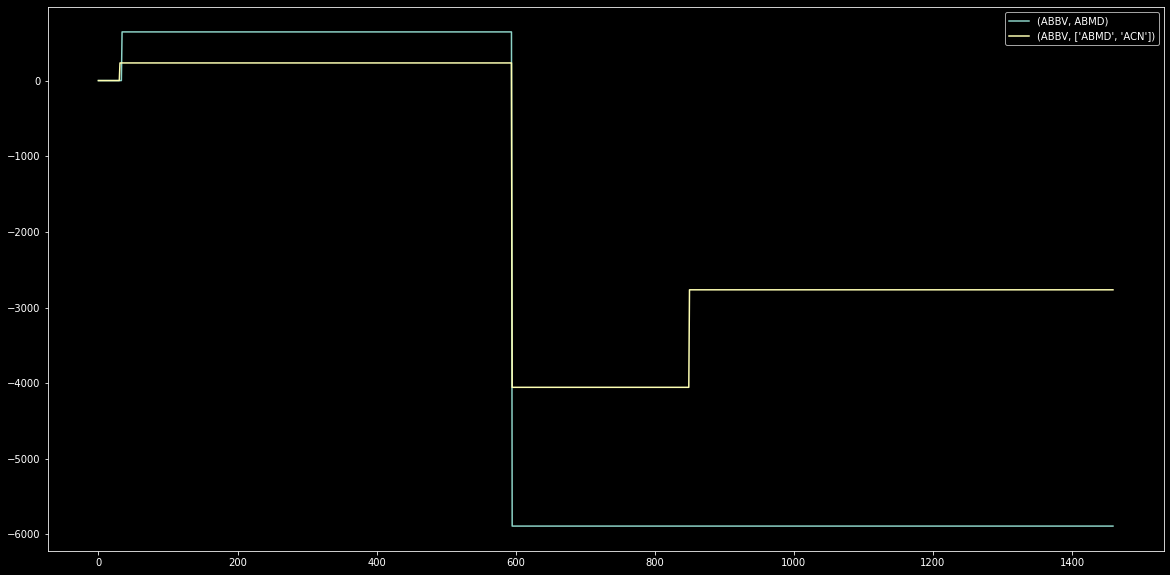

In [ ]:
window1 = 50   ##int(len(databank)*0.2)
all_returns = []
results = pd.DataFrame()
for num in range(0, 2):
    rets = backtest(num, window1)[0]
    all_returns.append(rets)
    results[tradable_pairs['Pears'].iloc[num]] = rets  #####   EXCLUDES WINDOW DATA
results.plot(figsize=(20,10))

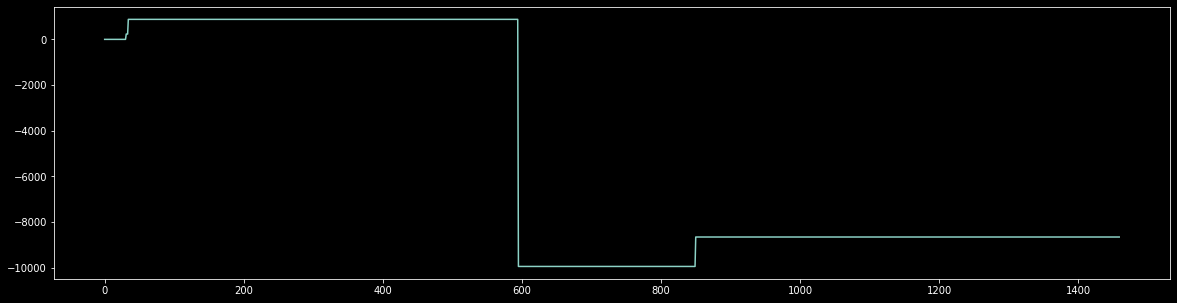

In [ ]:
results_df = results.sum(axis=1)
results_df.plot(figsize=(20,5))  

In [ ]:
stock1 = databank[tradable_pairs.iloc[4][0]][10:300]
stock2 = databank[tradable_pairs.iloc[4][1]][10:300]


zvalue = kal_spread(stock1, stock2)
std = zvalue.std()
std

0.06743640394698494

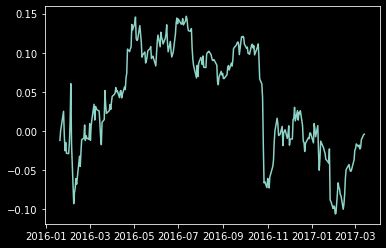

In [ ]:
plt.plot(zvalue)

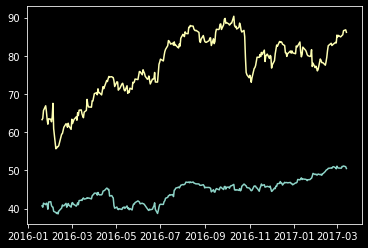

In [ ]:
plt.plot(stock1)
plt.plot(stock2)

In [ ]:
self.Securities[self.stock].Invested

